In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [2]:
df_old = pd.read_csv('/content/train.csv')

In [3]:
df = df_old.sample(n=50000)

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
231702,231702,10322,8685,How can I lose 4kg weight?,I'm 12 and at 60 kg and about 144 cm how do I ...,1
128644,128644,206832,206833,Naruto Gaiden: What is the story of Shin Uchiha?,Who Is Shin Uchiha from Naruto Gaiden?,1
74104,74104,127056,127057,How should I solve this question?,How do I solve this question?,0
166260,166260,258023,258024,What is a flash chamber in refrigeration system?,What is the need to cool a condenser in an ref...,0
292484,292484,20900,61946,Which is the best business to do in India with...,What is the best business to earn money in ind...,1


In [5]:
df.shape

(50000, 6)

In [6]:
df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 231702 to 179245
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   qid1          50000 non-null  int64 
 2   qid2          50000 non-null  int64 
 3   question1     50000 non-null  object
 4   question2     50000 non-null  object
 5   is_duplicate  50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.drop(columns=['id', 'qid1', 'qid2'], inplace=True)

is_duplicate
0    31516
1    18484
Name: count, dtype: int64
is_duplicate
0    63.032
1    36.968
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

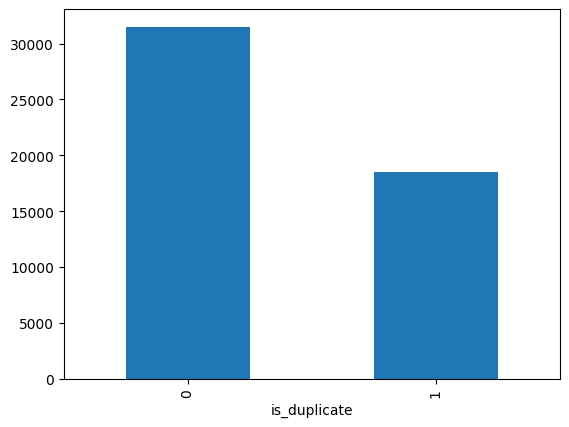

In [12]:
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [13]:
df.head()

,question1,question2,is_duplicate
231702,How can I lose 4kg weight?,I'm 12 and at 60 kg and about 144 cm how do I ...,1
128644,Naruto Gaiden: What is the story of Shin Uchiha?,Who Is Shin Uchiha from Naruto Gaiden?,1
74104,How should I solve this question?,How do I solve this question?,0
166260,What is a flash chamber in refrigeration system?,What is the need to cool a condenser in an ref...,0
292484,Which is the best business to do in India with...,What is the best business to earn money in ind...,1


In [15]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))
len(stop_words)

198

In [17]:
def preprocess(q):

  q = q.strip().lower()
  q = BeautifulSoup(q, 'html.parser').get_text()
  q = re.sub(r'http\S+|www\.\S+', '', q)
  q = ''.join(char for char in q if char not in string.punctuation)

  stop_words = set(stopwords.words('english'))
  q = " ".join([item for item in q.split() if item not in stop_words])

  ps = PorterStemmer()
  q = " ".join([ps.stem(word) for word in q.split()])

  return q


In [20]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [21]:
df.head()

,question1,question2,is_duplicate
231702,lose 4kg weight,im 12 60 kg 144 cm lose weight,1
128644,naruto gaiden stori shin uchiha,shin uchiha naruto gaiden,1
74104,solv question,solv question,0
166260,flash chamber refriger system,need cool condens refriger system,0
292484,best busi india less invest youth,best busi earn money india less invest,1


In [22]:
df.shape

(50000, 3)

In [23]:
df['q1_num_words'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_num_words'] = df['question2'].apply(lambda x: len(x.split()))

In [24]:
df['q1_len'] = df['question1'].apply(lambda x: len(x))
df['q2_len'] = df['question2'].apply(lambda x: len(x))

In [25]:
def common_words(row):

  q1 = row['question1']
  q2 = row['question2']

  q1 = set(q1.split())
  q2 = set(q2.split())
  return len(q1.intersection(q2))

In [26]:
df['common_words'] = df.apply(common_words, axis=1)

In [27]:
def total_words(row):

  q1 = row['question1']
  q2 = row['question2']

  q1 = set(q1.split())
  q2 = set(q2.split())
  return (len(q1) + len(q2))

In [28]:
df['total_words'] = df.apply(total_words, axis=1)

In [29]:
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [30]:
df.dropna(inplace=True)

In [31]:
df.head()

,question1,question2,is_duplicate,q1_num_words,q2_num_words,q1_len,q2_len,common_words,total_words,word_share
231702,lose 4kg weight,im 12 60 kg 144 cm lose weight,1,3,8,15,30,2,11,0.18
128644,naruto gaiden stori shin uchiha,shin uchiha naruto gaiden,1,5,4,31,25,4,9,0.44
74104,solv question,solv question,0,2,2,13,13,2,4,0.50
166260,flash chamber refriger system,need cool condens refriger system,0,4,5,29,33,2,9,0.22
292484,best busi india less invest youth,best busi earn money india less invest,1,6,7,33,38,5,13,0.38


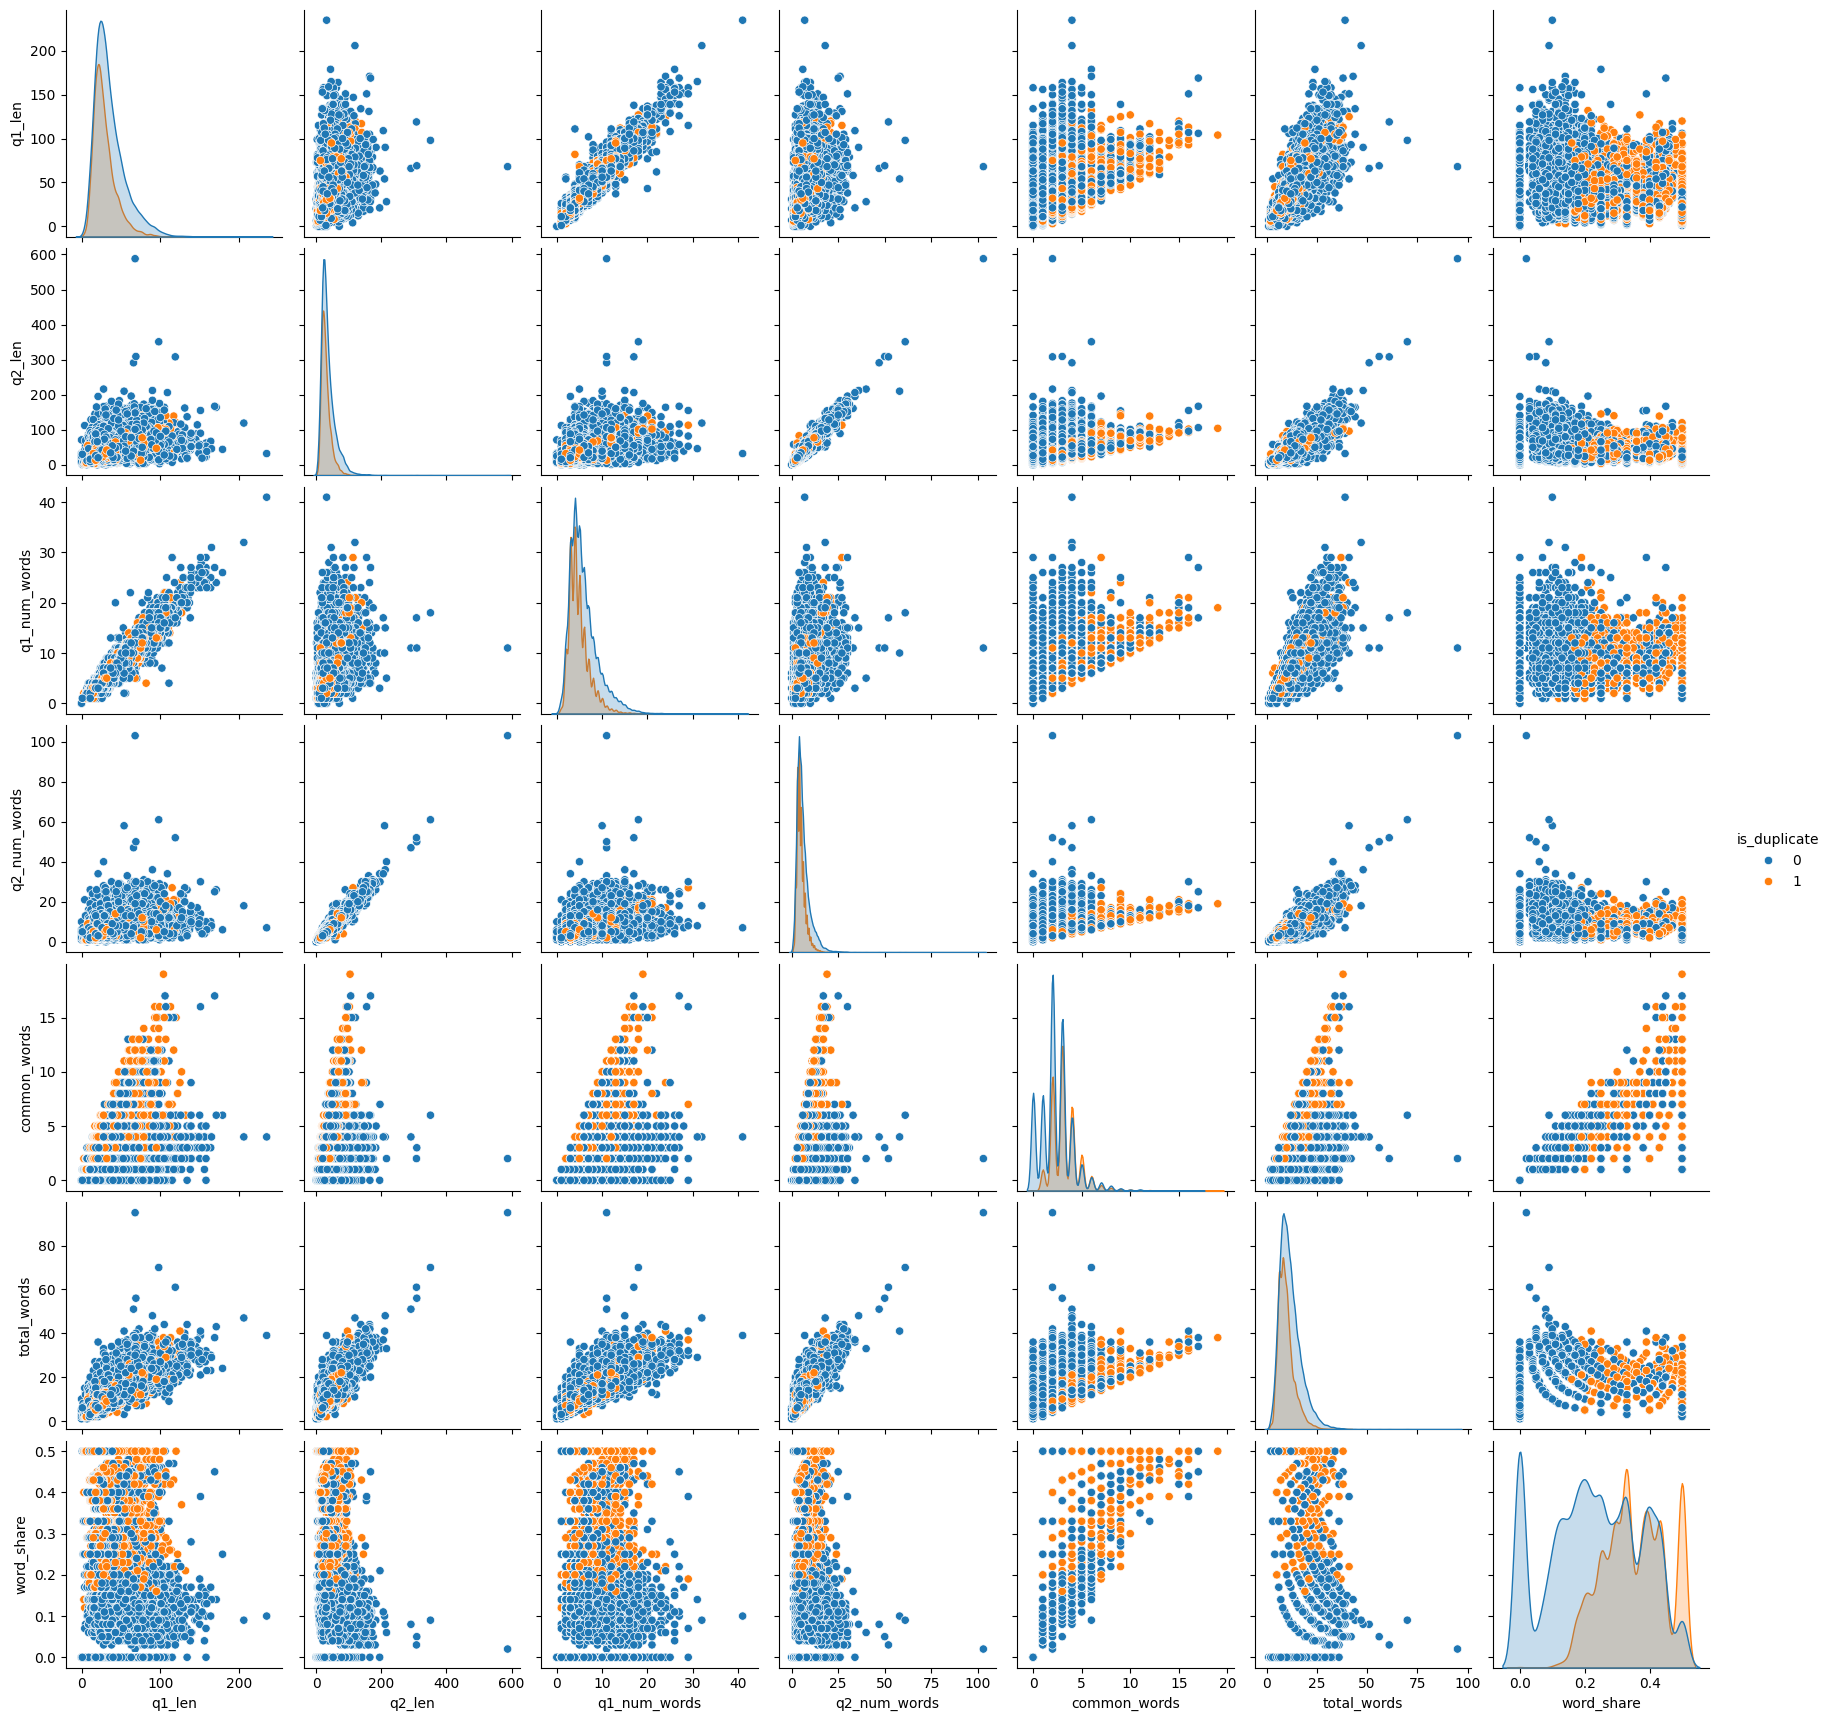

In [32]:
sns.pairplot(df[['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'common_words', 'total_words', 'word_share', 'is_duplicate']], hue='is_duplicate')

In [33]:
tfidf = TfidfVectorizer(max_features=3000)

# Fit on all text combined
all_text = pd.concat([df['question1'], df['question2']])
tfidf.fit(all_text)

# Now transform each column using the same TF-IDF model
q1 = tfidf.transform(df['question1']).toarray()
q2 = tfidf.transform(df['question2']).toarray()

In [34]:
q1_df = pd.DataFrame(q1)
q2_df = pd.DataFrame(q2)

q1_df.index = df.index
q2_df.index = df.index

df_combined = pd.concat([df, q1_df, q2_df], axis=1)

In [35]:
df_combined.shape

(49996, 6010)

In [36]:
X = df_combined.drop(columns=['question1', 'question2', 'is_duplicate']).values
y = df_combined['is_duplicate'].values

In [37]:
X.shape

(49996, 6007)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

In [39]:
mnb = MultinomialNB()

In [40]:
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.7457
[[5271 1066]
 [1477 2186]]
0.6722017220172202


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(
    n_estimators=50,     
    max_depth=15         
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6733
[[6259   78]
 [3189  474]]


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=50,
    max_depth=10
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7706
[[5587  750]
 [1544 2119]]


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    verbose=-1
)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(verbose=-1)

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7684
[[5508  829]
 [1487 2176]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
